In [10]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

import chure_model as model
consts = model.load_constants()

from matplotlib import pyplot as plt
from scipy.stats import linregress

plt.style.use('style.mpl')

In [11]:
# Load the gene metadata and the replicate averaged absolute abundance data
gene_metadata_df = pd.read_csv('../data/ecoli_genelist_master.csv', index_col=1)
abund_df = pd.read_csv('../data/Chure_mean_abundance_measurements.csv', index_col=0)
schmidt_data = pd.read_csv('../data/schmidt_2016_mean_abundance_measurements.csv', index_col=0)
slopes_df = pd.read_csv('../data/schmidt_2016_regression_slopes.csv', index_col=[0,1])

# Conditions of interest -- single carbon sources in batch
conds = ['fructose', 'fumarate', 'galactose',
         'glucosamine', 'glucose', 'glycerol',
         'mannose', 'pyruvate', 'succinate', 'xylose']

# Get the growth rates for each condition
lambdas = abund_df.groupby('dataset,condition'.split(',')).growth_rate_hr.first()
cond_lambdas = lambdas.loc['schmidt_2016', conds].reset_index().drop('dataset', axis=1).set_index('condition')

# Load ribosomal mass fractions from the Chure 2023 Elife paper
ribosome_mass_fractions = pd.read_csv('../data/ecoli_ribosomal_mass_fractions.csv')
peptide_elongation_rates = pd.read_csv('../data/ecoli_peptide_elongation_rates.csv')
peptide_elongation_rates.head()

,growth_rate_hr,elongation_rate_aa_s,source,notes
0,1.80,16.7,"Dai et al., 2016",Table S1
1,1.28,16.3,"Dai et al., 2016",Table S1
2,1.12,16.1,"Dai et al., 2016",Table S1
3,0.98,15.9,"Dai et al., 2016",Table S1
4,0.75,14.9,"Dai et al., 2016",Table S1


In [12]:
# Plotting dataframe for glucose/glycerol comparison
mask = schmidt_data.condition.isin('glucose,glycerol'.split(','))
two_conds = schmidt_data[mask].reset_index().pivot(
    index='b_number', columns='condition', values='copies_per_cell')

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


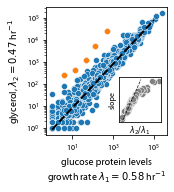

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2.25, 2.5))
pal = sns.color_palette()

my_ax = plt.gca()
plt.xscale('log')
plt.yscale('log')

log_x = np.log10(two_conds.glucose)
log_y = np.log10(two_conds.glycerol)
mask = np.logical_and(np.isfinite(log_x), np.isfinite(log_y)) 

# Use our simple estimate of the slope from above
est_slope = slopes_df.loc['glucose', 'glycerol'].huber_regression_slope
pred_xs = np.linspace(1, 1e5, 100)
pred_ys = est_slope*pred_xs

sns.scatterplot(data=two_conds, x='glucose', y='glycerol', color=pal[0])
plt.plot(pred_xs, pred_ys, color='k', ls='--')
#plt.text(0.95, 0.05, 'slope $\\approx {0:.2f}$'.format(est_slope),
#         transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=8)

gene_names = 'glpa,glpb,glpc,glpk,glpf,glpd'.split(',')
gene_data = gene_metadata_df.loc[gene_metadata_df.gene_name.isin(gene_names)]
b_nums = [b for b in gene_data.index.values if b in two_conds.index.values]
sns.scatterplot(data=two_conds.loc[b_nums], x='glucose', y='glycerol', color=pal[1], label='glp genes')
#plt.title('Global Expression Changes')
plt.xlabel('glucose protein levels\ngrowth rate $\\lambda_1 = {0}$ hr$^{{-1}}$'.format(cond_lambdas.loc['glucose'].growth_rate_hr))
plt.ylabel('glycerol, $\\lambda_2 = {0}$ hr$^{{-1}}$'.format(cond_lambdas.loc['glycerol'].growth_rate_hr))
plt.legend(fontsize=8, loc=2).set_visible(False)

# inset: lambda ratio vs fit slope, akin to Leeat's MSB paper. 
inset_ax = my_ax.inset_axes([0.6, 0.1, 0.35, 0.35])
xs = np.linspace(0.5, 1.5, 100)
inset_ax.plot(xs, xs, color='k', ls='--', lw=0.75, alpha=0.9)
sns.scatterplot(data=slopes_df, x='lambda_ratio', y='huber_regression_slope', color='grey', 
                sizes=3, ax=inset_ax)
inset_ax.set_xlabel('$\lambda_2 / \lambda_1$', fontsize=8, labelpad=2)
inset_ax.set_ylabel('trend slope', fontsize=8, labelpad=2)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.legend().set_visible(False)
inset_ax.tick_params(axis='both', which='both', length=0, pad=0)

plt.tight_layout(pad=0.1)
plt.savefig('../output/fig1_a.png', facecolor='white', dpi=300)
plt.show()

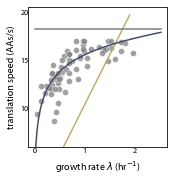

In [17]:
# Use Chure et al. model code to compute the ribosomal mass fraction
# for different strategies, as in the paper. 

# Load various constants
gamma_max = consts['gamma_max']
Kd_cpc = consts['Kd_cpc']
phi_O = consts['phi_O']
phiRb_range = np.linspace(0.0001, 1 - phi_O -0.001)

# Compute the continuous solutions for the scenarios.
nu_max = np.linspace(0.01, 20, 400)

phiRb_strat1 = 0.20 * np.ones(len(nu_max))
phiRb_strat2 = model.phiRb_constant_translation(gamma_max, nu_max, 10, Kd_cpc, phi_O)
phiRb_strat3 = model.phiRb_optimal_allocation(gamma_max, nu_max, Kd_cpc, phi_O)
lam_strat1 = model.steady_state_growth_rate(gamma_max, phiRb_strat1, nu_max, Kd_cpc, phi_O)
lam_strat2 = model.steady_state_growth_rate(gamma_max, phiRb_strat2, nu_max, Kd_cpc, phi_O)
lam_strat3 = model.steady_state_growth_rate(gamma_max, phiRb_strat3, nu_max, Kd_cpc, phi_O)
gamma_strat1 = model.steady_state_gamma(gamma_max, phiRb_strat1, nu_max, Kd_cpc, phi_O)
gamma_strat2 = model.steady_state_gamma(gamma_max, phiRb_strat2, nu_max, Kd_cpc, phi_O)
gamma_strat3 = model.steady_state_gamma(gamma_max, phiRb_strat3, nu_max, Kd_cpc, phi_O)

#%%
# Instantiate the figure for the data plots
plt.figure(figsize=(2.25, 2.5))
plt.xlabel('growth rate $\\lambda$ (hr$^{-1}$)\n ')
plt.ylabel('translation speed (AAs/s)')
plt.ylim([6, 20.5])
plt.yticks([10, 15, 20])

# Plot elongation rates
sns.scatterplot(data=peptide_elongation_rates, x='growth_rate_hr', y='elongation_rate_aa_s', alpha=0.75, color='grey')

# Plot the solutions fo the three scenarios
xkcd_colors = 'reddish purple|orange pink|dark blue green'.split('|')
pal = sns.xkcd_palette(xkcd_colors)
pal = sns.color_palette('cividis', n_colors=3)
for phi, lam, gam, c in zip([phiRb_strat1, phiRb_strat2, phiRb_strat3],
                            [lam_strat1, lam_strat2, lam_strat3],
                            [gamma_strat1, gamma_strat2, gamma_strat3],
                            [pal[2], pal[1], pal[0]]):
    plt.plot(lam, gam * consts['m_Rb'] / 3600, '-', lw=1.5, color=c)

plt.tight_layout(pad=0.1)
plt.savefig('../output/fig1_d.png', facecolor='white', dpi=300)
plt.show()

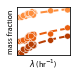

In [16]:
plt.figure(figsize=(0.9, 0.9))

ribosomal_genes = 'rpla,rpsa,tufa'.split(',')
nice_gene_names = 'rplA,rpsA,tufA'.split(',')
ribosomal_b_nums = gene_metadata_df[gene_metadata_df.gene_name.isin(ribosomal_genes)].index.values
bnum2name = dict(zip(ribosomal_b_nums, nice_gene_names))

tmp = schmidt_data.reset_index()
tmp = tmp[tmp.b_number.isin(ribosomal_b_nums)].copy()
tmp['gene_name'] = tmp.b_number.apply(lambda x: bnum2name[x])

plt.yscale('log')
pal = sns.color_palette('Oranges_r', n_colors=5)
sns.scatterplot(data=tmp, x='growth_rate_hr', y='mass_fraction',
                hue='gene_name', palette=pal[:3], sizes=3,
                hue_order=nice_gene_names)

for i, b in enumerate(ribosomal_b_nums):
    x = tmp[tmp.b_number == b].growth_rate_hr
    y = tmp[tmp.b_number == b].mass_fraction
    reg = linregress(x, y)
    pred_xs = np.linspace(x.min(), x.max(), 100)
    pred_ys = reg.slope*pred_xs + reg.intercept
    plt.plot(pred_xs, pred_ys, color=pal[i], ls='--', zorder=-10)

plt.xlabel('$\lambda$ (hr$^{-1}$)', fontsize=8, labelpad=2)
plt.ylabel('mass fraction', fontsize=8, labelpad=2)
plt.legend(title=None, fontsize=8).set_visible(False)
plt.xticks([])
plt.yticks([])
plt.tick_params(axis='both', which='both', length=0, pad=0)

plt.tight_layout(pad=0.1)
plt.savefig('../output/fig1_c.png', dpi=300)
plt.show()